[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/tutorials/feature-use/global_local_modeling.ipynb)


# Global Local Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which a single time series may not reflect the entire time series dynamics. In addition, global models provide better generalization and model size saving.

However, in cases where many time series share only some behaviors, a **global local model** may be more appropriate. In this type of model, a single model with shared weights is used to capture the common behaviors across the time series, while some components are modeled separately for each time series.

In this notebook, we will demonstrate an example of Global Local Modelling by modeling trend and seasonality components separately for each time series in the ERCOT region's hourly load dataset.

First, we load the data:

In [1]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
import numpy as np

set_random_seed(10)
set_log_level("ERROR", "INFO")

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")
df_ercot.head()

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32


We extract the name of the regions which will be later used in the model creation.

In [3]:
regions = list(df_ercot)[1:]

Global models can be enabled when the `df` input of the function has an additional column 'ID', which identifies the different time-series (besides the typical column 'ds', which has the timestamps, and column 'y', which contains the observed values of the time series). We select data from a three-year interval in our example (from 2004 to 2007).

In [4]:
df_global = pd.DataFrame()
for col in regions:
    aux = df_ercot[["ds", col]].copy(deep=True)  # select column associated with region
    aux = aux.iloc[:26301, :].copy(deep=True)  # selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns={col: "y"})  # rename column of data to 'y' which is compatible with Neural Prophet
    aux["ID"] = col
    df_global = pd.concat((df_global, aux))

We will modify the trend for NORTH and the seasonality for COAST.

<AxesSubplot:>

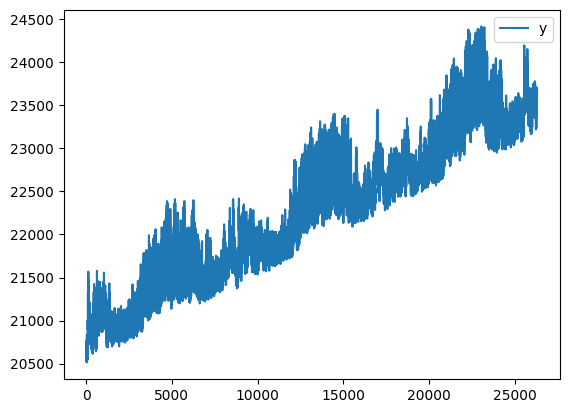

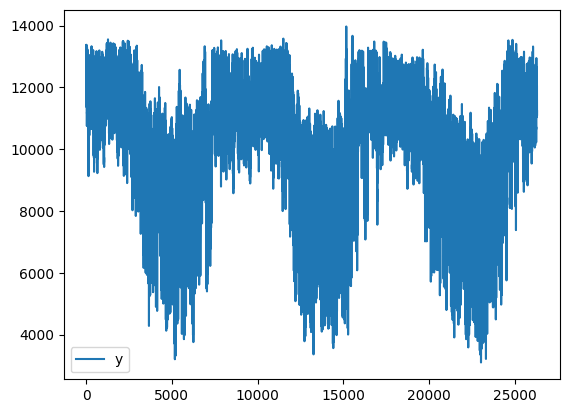

In [5]:
df_global["y"] = (
    np.where(df_global["ID"] == "COAST", -df_global["y"], df_global["y"])
    + 2 * df_global.loc[df_global["ID"] == "COAST", "y"].mean()
)
df_global["y"] = np.where(df_global["ID"] == "NORTH", df_global["y"] + 0.1 * df_global.index, df_global["y"])

df_global.loc[df_global["ID"] == "NORTH"].plot()
df_global.loc[df_global["ID"] == "COAST"].plot()

## Global Modeling
**Remark:** Training a time series only with trend and seasonality components can result in poor performance. The following example is used just to show the new local modelling of multiple time series functionality.

In [6]:
m = NeuralProphet(
    trend_global_local="global",
    season_global_local="global",
    changepoints_range=0.8,
    epochs=20,
    trend_reg=5,
)

When a pd.DataFrame with an 'ID' column is the input for the `split_df` function, train and validation data are provided in a similar format. For global models, the input data is typically split according to a fraction of the time encompassing all time series (default when there is more than one 'ID' and when `local_split=False`). If the user wants to split each time series locally, the `local_split` parameter must be set to True. In this example, we will split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

In [7]:
df_train, df_test = m.split_df(df_global, valid_p=0.33, local_split=True)
print(df_train.shape, df_test.shape)

(140976, 3) (69432, 3)


After creating an object of the `NeuralProphet`, a model can be created by calling the `fit` function.

In [8]:
metrics = m.fit(df_train, freq="H")

Finding best initial lr:   0%|          | 0/278 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Ensure you provide data identified with the keys associated with the appropriate train time series. Therefore, suitable normalization data parameters are used in post-fitting procedures (i.e., `predict`, `test`).

In [9]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

We will plot now the forecast time series and the parameters for:
- NORTH: With an adjusted trend
- COAST: With an adjusted seasonality
- EAST: No changes to the original

### North

In [10]:
m.plot(forecast[forecast["ID"] == "NORTH"])

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~9h</i>',
              'type': 'scatter',
              'uid': '9a108160-ca64-46e9-a57f-2342e2418a7f',
              'x': array([datetime.datetime(2006, 1, 4, 9, 0),
                          datetime.datetime(2006, 1, 4, 17, 0),
                          datetime.datetime(2006, 1, 4, 21, 0), ...,
                          datetime.datetime(2006, 12, 31, 15, 0),
                          datetime.datetime(2006, 12, 31, 21, 0),
                          datetime.datetime(2007, 1, 1, 1, 0)], dtype=object),
              'y': array([21642.59570312, 22050.99414062, 22088.8671875 , ..., 21963.77539062,
                          22115.85742188, 21792.71679688])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers'

In [11]:
m.plot_parameters(df_name="NORTH")

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~18h</i>',
              'type': 'scatter',
              'uid': '7e3e0a14-7292-4c2a-92ca-50111dd2a9cb',
              'x': array([datetime.datetime(2004, 1, 1, 1, 0),
                          datetime.datetime(2004, 1, 1, 15, 0),
                          datetime.datetime(2004, 1, 2, 12, 0), ...,
                          datetime.datetime(2006, 1, 3, 13, 0),
                          datetime.datetime(2006, 1, 3, 14, 0),
                          datetime.datetime(2006, 1, 4, 8, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([21640.43347138, 21639.90027296, 21639.10047533, ..., 21915.01216393,
                          21915.03223708, 21915.39355386]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
   

### South

In [12]:
m.plot(forecast[forecast["ID"] == "COAST"])

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~9h</i>',
              'type': 'scatter',
              'uid': '68cb3cb8-d455-4099-844e-f8f1eebbce13',
              'x': array([datetime.datetime(2006, 1, 4, 9, 0),
                          datetime.datetime(2006, 1, 4, 17, 0),
                          datetime.datetime(2006, 1, 4, 21, 0), ...,
                          datetime.datetime(2006, 12, 31, 15, 0),
                          datetime.datetime(2006, 12, 31, 21, 0),
                          datetime.datetime(2007, 1, 1, 1, 0)], dtype=object),
              'y': array([7812.15625   , 9477.49707031, 9631.93554688, ..., 9121.84375   ,
                          9741.99707031, 8424.31640625])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
    

In [13]:
m.plot_parameters(df_name="COAST")

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~18h</i>',
              'type': 'scatter',
              'uid': '7a7cfd16-9ed0-41fa-addf-44fe1abbe334',
              'x': array([datetime.datetime(2004, 1, 1, 1, 0),
                          datetime.datetime(2004, 1, 1, 18, 0),
                          datetime.datetime(2004, 1, 1, 21, 0), ...,
                          datetime.datetime(2006, 1, 2, 22, 0),
                          datetime.datetime(2006, 1, 3, 19, 0),
                          datetime.datetime(2006, 1, 4, 8, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([7803.34388175, 7800.70372939, 7800.23782015, ..., 8921.77588108,
                          8923.49479516, 8924.55888483]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
         

### East

In [14]:
m.plot(forecast[forecast["ID"] == "EAST"])

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~9h</i>',
              'type': 'scatter',
              'uid': '62de9134-bcf7-49d3-a332-b93dd37097b0',
              'x': array([datetime.datetime(2006, 1, 4, 9, 0),
                          datetime.datetime(2006, 1, 4, 17, 0),
                          datetime.datetime(2006, 1, 4, 21, 0), ...,
                          datetime.datetime(2006, 12, 31, 15, 0),
                          datetime.datetime(2006, 12, 31, 21, 0),
                          datetime.datetime(2007, 1, 1, 1, 0)], dtype=object),
              'y': array([21167.76953125, 21376.86523438, 21396.25585938, ..., 21332.2109375 ,
                          21410.07421875, 21244.63085938])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers'

In [15]:
m.plot_parameters(df_name="EAST")

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~18h</i>',
              'type': 'scatter',
              'uid': '44b51430-0a8f-4cb2-b292-efde0bcacdd0',
              'x': array([datetime.datetime(2004, 1, 1, 1, 0),
                          datetime.datetime(2004, 1, 1, 18, 0),
                          datetime.datetime(2004, 1, 2, 9, 0), ...,
                          datetime.datetime(2006, 1, 2, 21, 0),
                          datetime.datetime(2006, 1, 4, 4, 0),
                          datetime.datetime(2006, 1, 4, 8, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([21166.66363902, 21166.33214932, 21166.03965841, ..., 21307.0803654 ,
                          21307.39895942, 21307.44006832]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
     

### Metrics

In [16]:
test_metrics_global = m.test(df_test)
test_metrics_global

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.04403695836663246
         MAE_val            0.24501539766788483
        RMSE_val            0.2753794193267822
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,0.245015,0.275379,0.044037,0.0


## Local Modelling of Trend and Seasonality
We will repeat the process above, but for local modelling of trend and seasonality.

In [17]:
m = NeuralProphet(
    trend_global_local="local",
    season_global_local="local",
    changepoints_range=0.8,
    epochs=20,
    trend_reg=5,
)

In [18]:
metrics = m.fit(df_train, freq="H")

Finding best initial lr:   0%|          | 0/278 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [19]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

### North

In [20]:
m.plot(forecast[forecast["ID"] == "NORTH"])

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~9h</i>',
              'type': 'scatter',
              'uid': '4b64d853-aefa-47ad-a7ac-1f4e758cba9c',
              'x': array([datetime.datetime(2006, 1, 4, 9, 0),
                          datetime.datetime(2006, 1, 4, 17, 0),
                          datetime.datetime(2006, 1, 4, 21, 0), ...,
                          datetime.datetime(2006, 12, 31, 14, 0),
                          datetime.datetime(2006, 12, 31, 21, 0),
                          datetime.datetime(2007, 1, 1, 1, 0)], dtype=object),
              'y': array([22368.94726562, 22594.56640625, 22638.4765625 , ..., 23858.15039062,
                          23993.84179688, 23782.18945312])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers'

In [21]:
m.plot_parameters(df_name="NORTH")

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~18h</i>',
              'type': 'scatter',
              'uid': '8b3d7e06-1b46-42e9-9843-e0c54f30c6cc',
              'x': array([datetime.datetime(2004, 1, 1, 1, 0),
                          datetime.datetime(2004, 1, 1, 17, 0),
                          datetime.datetime(2004, 1, 2, 12, 0), ...,
                          datetime.datetime(2006, 1, 3, 11, 0),
                          datetime.datetime(2006, 1, 4, 6, 0),
                          datetime.datetime(2006, 1, 4, 8, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([21670.30849778, 21668.82448841, 21667.0622273 , ..., 22650.66786445,
                          22653.71758754, 22654.03861102]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
    

### Coast

In [22]:
m.plot(forecast[forecast["ID"] == "COAST"])

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~9h</i>',
              'type': 'scatter',
              'uid': '8c5a58ae-af89-42e9-8e42-6419234e40cd',
              'x': array([datetime.datetime(2006, 1, 4, 9, 0),
                          datetime.datetime(2006, 1, 4, 17, 0),
                          datetime.datetime(2006, 1, 4, 21, 0), ...,
                          datetime.datetime(2006, 12, 31, 15, 0),
                          datetime.datetime(2006, 12, 31, 20, 0),
                          datetime.datetime(2007, 1, 1, 1, 0)], dtype=object),
              'y': array([12996.6328125 , 10609.34472656, 10710.04492188, ..., 11201.65039062,
                          10649.11035156, 12241.17382812])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers'

In [23]:
m.plot_parameters(df_name="COAST")

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~18h</i>',
              'type': 'scatter',
              'uid': '42abb0fe-f3b3-4ae4-90ca-18f690cb6df5',
              'x': array([datetime.datetime(2004, 1, 1, 1, 0),
                          datetime.datetime(2004, 1, 1, 12, 0),
                          datetime.datetime(2004, 1, 2, 11, 0), ...,
                          datetime.datetime(2006, 1, 2, 23, 0),
                          datetime.datetime(2006, 1, 3, 20, 0),
                          datetime.datetime(2006, 1, 4, 8, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 7925.16639325,  7931.9603421 ,  7946.16587152, ..., 10720.86187197,
                          10719.83779184, 10719.2526032 ]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
   

### East

In [24]:
m.plot(forecast[forecast["ID"] == "EAST"])

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~9h</i>',
              'type': 'scatter',
              'uid': '04de4552-33ff-417f-896c-a1ab9112860d',
              'x': array([datetime.datetime(2006, 1, 4, 9, 0),
                          datetime.datetime(2006, 1, 4, 17, 0),
                          datetime.datetime(2006, 1, 4, 21, 0), ...,
                          datetime.datetime(2006, 12, 31, 15, 0),
                          datetime.datetime(2006, 12, 31, 21, 0),
                          datetime.datetime(2007, 1, 1, 1, 0)], dtype=object),
              'y': array([21010.73828125, 21314.1953125 , 21341.1328125 , ..., 21129.7734375 ,
                          21238.76757812, 21007.38476562])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers'

In [25]:
m.plot_parameters(df_name="EAST")

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~18h</i>',
              'type': 'scatter',
              'uid': 'c6102307-9eee-4667-883f-3dca39b7ac5d',
              'x': array([datetime.datetime(2004, 1, 1, 1, 0),
                          datetime.datetime(2004, 1, 1, 6, 0),
                          datetime.datetime(2004, 1, 2, 12, 0), ...,
                          datetime.datetime(2006, 1, 3, 0, 0),
                          datetime.datetime(2006, 1, 3, 14, 0),
                          datetime.datetime(2006, 1, 4, 8, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([21181.95931213, 21181.90439468, 21181.57488996, ..., 21232.19887713,
                          21232.27479755, 21232.37240952]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
     

### Metric

In [26]:
test_metrics_local = m.test(df_test)
test_metrics_local

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.022835642099380493
         MAE_val            0.17058391869068146
        RMSE_val            0.20273050665855408
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,0.170584,0.202731,0.022836,0.0


## Conclusion
Comparing the local global model and the global model, we achieved a lower error with global local model.